Welcome to prioMorph! TNBC
Building cells dicts..


100%|██████████| 1/1 [00:13<00:00, 13.64s/it]


total annotated cell types : 15
total patients : 1
[4, 8, 10, 6, 14, 1, 12, 7, 16, 2, 15, 3, 11, 9, 13]

#############################################



100%|██████████| 500/500 [06:04<00:00,  1.37it/s]


=> Saving checkpoint
=> Saving checkpoint
             model    r2_val
0        neighbors  0.242797
1  neighbors_morph  0.286318


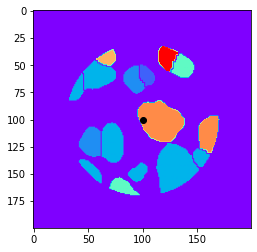

In [12]:
import sys
import pandas as pd

from torch.utils.data import DataLoader
from models import SimpleLinearNet
import copy
import torch
from tqdm import tqdm
from sklearn.metrics import r2_score
###
import utils
from ProcessData import CellsDataSetTNBC
tnbc_df = pd.read_csv(r'../data/cellDataDemo.csv').iloc[:,1:]#Drop index col
types = pd.read_csv(r'../data/MIBI_TNBC_idx_cell_to_type.csv')
###
tnbc_df = tnbc_df[tnbc_df['SampleID'].isin([1])]
###tnbc cols to drop
cols_to_drop = ['cellSize','C','Na','Si','P','Ca','Fe','Background','B7H3','OX40','CD163', 'CSF-1R',
                'Ta','Au','tumorYN','tumorCluster','Group','immuneCluster','immuneGroup']

tnbc_neighbors_data = CellsDataSetTNBC(data_path = r'.',
                                         cells_data_df = tnbc_df,
                                         types_present_in_csv = True,
                                         cols_to_drop = cols_to_drop,
                                         types_data_df = types,
                                         meta_data_df = None,
                                         mode = 'neighbors_morph')
print()
print('###'*15)
print()
## view example of a cell and it's microenv:
tnbc_neighbors_data.view_neighbors(1, 500)
## data generator
tnbc_neighbors_loader  = DataLoader(tnbc_neighbors_data, batch_size = 64, shuffle = True)
## load to disk for faster training
tnbc_dataset, tnbc_batches, tnbc_patients_ids = utils.buildDataSet(tnbc_neighbors_loader)
## train-test split
tnbc_train_data, tnbc_train_patients_id,tnbc_test_data, tnbc_test_patients_id = utils.train_test_split(tnbc_dataset, 
                                                                                                tnbc_patients_ids)

### model HP : 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 500
tnbc_lr = 4e-3

##load models :
tnbc_model_full = SimpleLinearNet(in_features = tnbc_train_data[0]['x'].shape[1], out_features = tnbc_train_data[0]['y'].shape[1]).to(device)
tnbc_model_null = SimpleLinearNet(in_features = tnbc_train_data[0]['x'].shape[1] - 12, out_features = tnbc_train_data[0]['y'].shape[1]).to(device)

### params for each model
tnbc_criterion = torch.nn.MSELoss()
tnbc_optimizer_full = torch.optim.Adam(params = tnbc_model_full.parameters(), lr = tnbc_lr)
tnbc_optimizer_null = torch.optim.Adam(params = tnbc_model_null.parameters(), lr = tnbc_lr)

### track loss
tnbc_train_loss = {'null' : [], 'full' : []}
tnbc_val_loss = {'null' : [], 'full' : []}
best_loss_full = 100
best_loss_null = 100

#### Training loop!
for epoch in tqdm(range(EPOCHS)):
    ### train tnbc model - 1 with morph fts, and one without
    train_l_full = utils.train_one_epoch(tnbc_model_full, tnbc_train_data, tnbc_optimizer_full, tnbc_criterion, device, mode = 'full')
    eval_l_full = utils.eval_one_epoch(tnbc_model_full, tnbc_train_data, tnbc_criterion, device, mode = 'full')
    if eval_l_full < best_loss_full:
        tnbc_best_wts_full = copy.deepcopy(tnbc_model_full.state_dict())
        best_loss_full = eval_l_full
        ef = epoch
    tnbc_train_loss['full'].append(train_l_full)
    tnbc_val_loss['full'].append(eval_l_full)
    ### train null model
    train_l_null = utils.train_one_epoch(tnbc_model_null, tnbc_train_data, tnbc_optimizer_null, tnbc_criterion, device, mode = 'null')
    eval_l_null = utils.eval_one_epoch(tnbc_model_null, tnbc_train_data, tnbc_criterion, device, mode = 'null')
    if eval_l_null < best_loss_null:
        tnbc_best_wts_null = copy.deepcopy(tnbc_model_null.state_dict())
        best_loss_null = eval_l_null
        en = epoch
    tnbc_train_loss['null'].append(train_l_null)
    tnbc_val_loss['null'].append(eval_l_null)
## save best models:
tnbc_model_full.load_state_dict(tnbc_best_wts_full)
tnbc_model_null.load_state_dict(tnbc_best_wts_null)
utils.save_model1(tnbc_model_full, filename = 'shape.pkl')
utils.save_model1(tnbc_model_null, filename = 'no_shape.pkl')

tnbc_models = {'full' : tnbc_model_full, 'null' : tnbc_model_null}
test_trues_b, test_preds_b = utils.getPreds(tnbc_models, tnbc_test_data, device, mode = 'null')
test_trues_bm, test_preds_bm = utils.getPreds(tnbc_models, tnbc_test_data,device, mode = 'full')
all_trues = {'n' : [test_trues_b, test_trues_bm]}
all_preds = {'n' : [test_preds_b, test_preds_bm]}
def buildBoxPlotR2():
    bbox_dict = {'model':[], 'r2_val':[]}
    for mode in ['neighbors', 'neighbors_morph']:
        sp = mode.split('_')
        if len(sp) == 2:
            first = sp[0][0]
            trues, preds = all_trues[first][1], all_preds[first][1] 
        else:
            first = sp[0][0]
            trues, preds = all_trues[first][0], all_preds[first][0]
        r2 = r2_score(trues,preds,multioutput = 'variance_weighted')
            
        bbox_dict['model'].append(mode)
        bbox_dict['r2_val'].append(r2)
              
              
    boxplot_df = pd.DataFrame(bbox_dict)
    return boxplot_df
df = buildBoxPlotR2()
print(df)
df.to_csv('Results.csv')
## create imp df
importance_df = utils.feature_importance(tnbc_model_full.to(device), tnbc_train_data[0]['x'].to(device), num_target_features = 36)
importance_df.to_csv('Shape_ft_importance.csv')

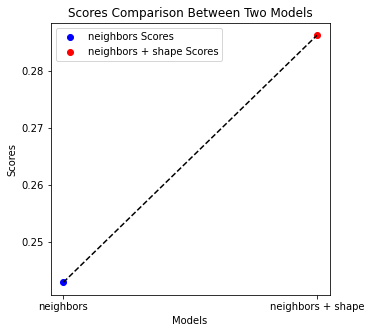

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def plot(data_scores, save = None):
    names = list(data_scores.keys())
    model_1_scores = data_scores[names[0]]
    model_2_scores = data_scores[names[1]]
    x_positions = np.arange(len(data_scores))
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(np.zeros_like(model_1_scores), model_1_scores, color='blue', label=f'{names[0]} Scores')
    ax.scatter(np.ones_like(model_2_scores), model_2_scores, color='red', label=f'{names[1]} Scores')
    for i in range(len(model_1_scores)):
        ax.plot(x_positions, [model_1_scores[i], model_2_scores[i]], 'k--')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(list(data_scores.keys()))
    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title('Scores Comparison Between Two Models')
    plt.legend()
    if save is not None:
        plt.savefig(f'{save}.svg', format = 'svg', dpi = 200)
    plt.show()
    
r2_df = pd.read_csv('Results.csv')

data_scores_neighbors = {
        'neighbors': [r2_df.iloc[0,1]],
        'neighbors + shape': [r2_df.iloc[1,1]]
    }
plot(data_scores_neighbors)

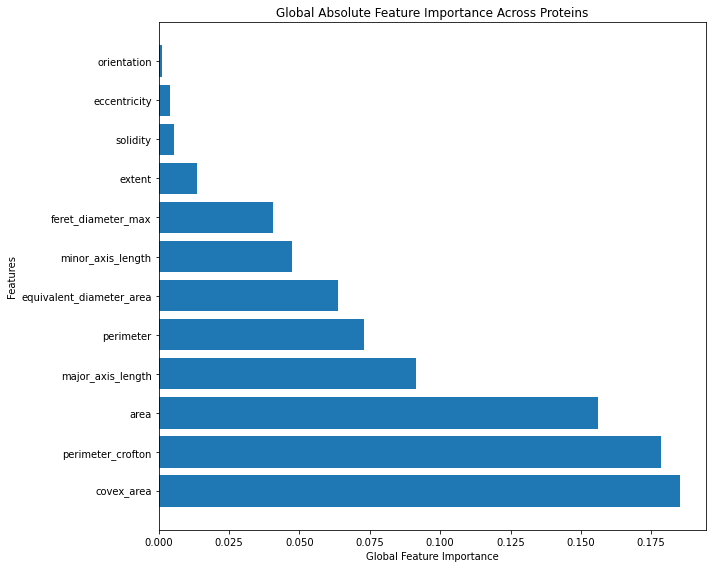

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
cells = ['Unidentified','Endothelial','Mesenchyme', 'Tumor','Tregs','CD4 t cells',
                                       'CD8 T cells', 'CD3 T cells', 'NK cells', 'B cells', 'Neutrophils','Macrophages',
                                       'DC', 'DC/Mono', 'Mono/Neu', 'Immune other']


names = cells + cells+['num_neighbors']+ ['area', 'eccentricity','major_axis_length',
                      'minor_axis_length','perimeter','equivalent_diameter_area','covex_area','extent',
                     'feret_diameter_max','orientation','perimeter_crofton','solidity']

cols = ['dsDNA', 'Vimentin', 'SMA', 'FoxP3', 'Lag3', 'CD4', 'CD16', 'CD56',
                   'PD1', 'CD31', 'PD-L1', 'EGFR', 'Ki67', 'CD209', 'CD11c', 'CD138',
                   'CD68', 'CD8', 'CD3', 'IDO', 'Keratin17', 'CD63', 'CD45RO', 'CD20',
                   'p53', 'Beta catenin', 'HLA-DR', 'CD11b', 'CD45', 'H3K9ac',
                   'Pan-Keratin', 'H3K27me3', 'phospho-S6', 'MPO', 'Keratin6',
                   'HLA_Class_1']

# Assuming your feature importance dataframe is called 'feature_importance_df'
# and has features as index and targets as columns
feature_importance_df = pd.read_csv("Shape_ft_importance.csv", index_col = 0)
feature_importance_df = feature_importance_df.iloc[-12:, :]
feature_importance_df.columns = cols
feature_importance_df.index = names[-12:]
feature_importance_df.columns

# Calculate the mean absolute feature importance across all targets
global_importance = feature_importance_df.abs().mean(axis=1)
sorted_features = global_importance.sort_values(ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_features)), sorted_features.values)
plt.yticks(range(len(sorted_features)), sorted_features.index)
plt.xlabel('Global Feature Importance')
plt.ylabel('Features')
plt.title('Global Absolute Feature Importance Across Proteins')
plt.tight_layout()
plt.savefig('Global_imp_tnbc.svg', format = "svg")
plt.show()

Text(0, 0.5, 'Attribution')

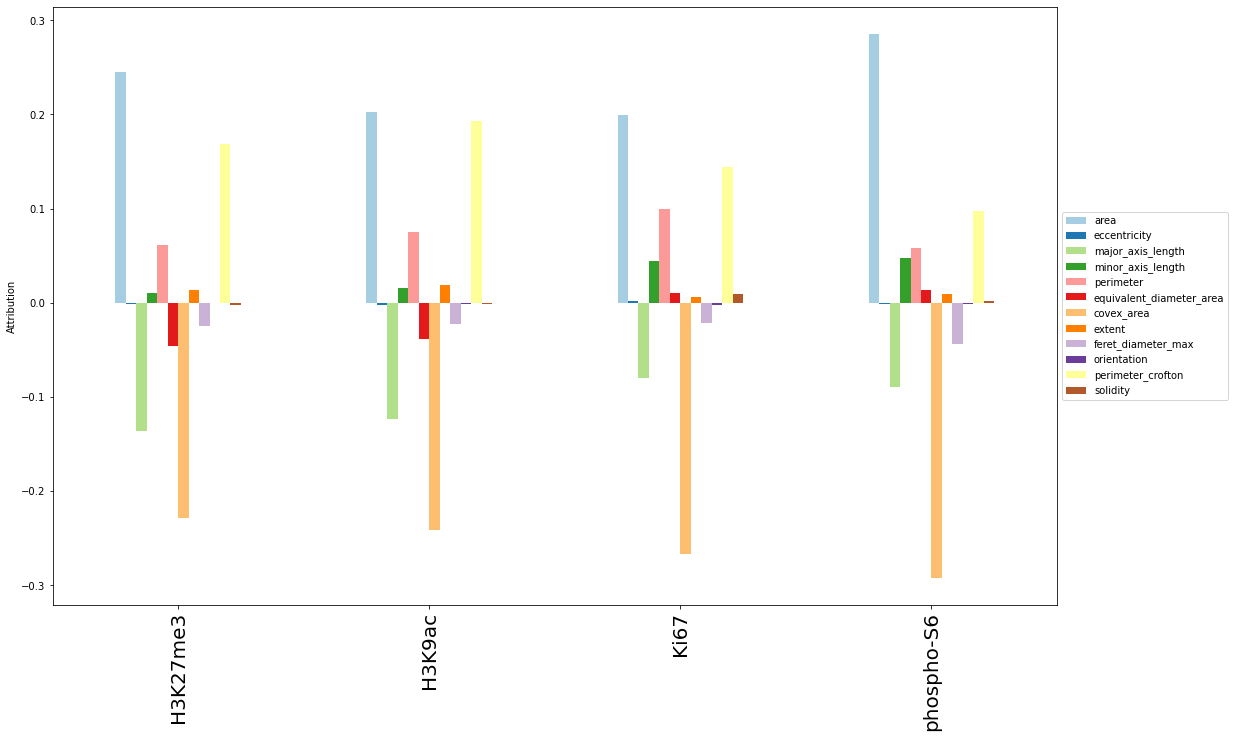

In [5]:
only_status_markers = ['H3K27me3', 'H3K9ac','Ki67','phospho-S6']
only_st = feature_importance_df[only_status_markers]
ax = only_st.T.iloc[:, -12:].plot(kind = 'bar',figsize=(18,11), label = names[-12:], colormap='Paired')
ax.set_xticklabels(only_status_markers, fontsize = 20)
ax.legend(names[-12:],loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Attribution')